In [1]:
import os
import numpy as np
import cv2 as cv

In [2]:
IMG_SIZE = (80, 80)
NUM_TOP_CHARACTERS = 10
char_path = './Resources/simpsons_dataset'
preprocessed_path = './preprocessed_images'

In [3]:
# Get list of top characters based on number of images
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))

sorted_chars = sorted(char_dict.items(), key=lambda item: item[1], reverse=True)
top_characters = [char for char, count in sorted_chars[:NUM_TOP_CHARACTERS]]

# Create directory to save preprocessed images
os.makedirs(preprocessed_path, exist_ok=True)

# Function to preprocess and save image
def preprocess_image(character, image_name, image_path):
    # Create subdirectory for the character if it doesn't exist
    character_dir = os.path.join(preprocessed_path, character)
    os.makedirs(character_dir, exist_ok=True)
    
    # Generate unique name for the image
    save_name = f'{character}_{image_name}'
    save_path = os.path.join(character_dir, save_name)
    
    # Preprocess and save the image
    image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    if image is not None and image.size > 0:
        image = cv.resize(image, IMG_SIZE)
        cv.imwrite(save_path, image)
    else:
        print(f"Error: Failed to preprocess image '{image_path}' for character '{character}'")

# Preprocess and save images
for character in top_characters:
    character_path = os.path.join(char_path, character)
    for image_name in os.listdir(character_path):
        image_path = os.path.join(character_path, image_name)
        preprocess_image(character, image_name, image_path)


In [77]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader

data_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming grayscale images
])

dataset = ImageFolder(root=preprocessed_path, transform=data_transforms)


In [78]:
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [69]:
for inputs, labels in train_loader:
    print(inputs.shape)  # Should print torch.Size([batch_size, 1, 80, 80])
    print(labels.shape)  # Should print torch.Size([batch_size])
    break  # Stop after printing one batch for demonstration

torch.Size([32, 1, 80, 80])
torch.Size([32])


In [83]:
import torch
import torch.nn as nn 
import torch.optim as optim

num_epochs = 20

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # 32 filters, output size = (32, 80, 80)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # output size = (32, 40, 40)
    nn.Dropout(0.2),  # Add dropout with probability 0.2

    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 64 filters, output size = (64, 40, 40)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),  # output size = (64, 20, 20)

    nn.Flatten(),  # Flatten the output for dense layers

    nn.Linear(64*20*20, 128),  # Dense layer with 128 neurons
    nn.ReLU(),

    nn.Linear(128, 64),  # Adding another dense layer with 64 neurons
    nn.ReLU(),

    nn.Linear(64, 10)  # Output layer with 10 neurons for classification (assuming 10 classes)
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()

    for inputs, labels in train_loader:
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    
    # Store training loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()  # Set model in evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs_val, labels_val in test_loader:
            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)
            outputs_val = model(inputs_val)
            val_loss = criterion(outputs_val, labels_val)
            running_val_loss += val_loss.item() * inputs_val.size(0)
            
            _, predicted_val = torch.max(outputs_val, 1)
            correct_val += (predicted_val == labels_val).sum().item()
            total_val += labels_val.size(0)
    
    # Calculate average validation loss and accuracy
    val_loss = running_val_loss / len(test_loader.dataset)
    val_accuracy = correct_val / total_val
    
    # Store validation loss and accuracy
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    # Print progress
    print(f'Epoch {epoch+1}/{num_epochs}, '
        f'Training Loss: {train_loss:.4f}, '
        f'Training Accuracy: {100 * train_accuracy:.2f}%, '
        f'Validation Loss: {val_loss:.4f}, '
        f'Validation Accuracy: {100 * val_accuracy:.2f}%')

Epoch 1/20, Training Loss: 2.1214, Training Accuracy: 23.89%, Validation Loss: 2.0205, Validation Accuracy: 30.22%
Epoch 2/20, Training Loss: 1.9329, Training Accuracy: 32.59%, Validation Loss: 1.8987, Validation Accuracy: 33.41%
Epoch 3/20, Training Loss: 1.8106, Training Accuracy: 37.55%, Validation Loss: 1.7916, Validation Accuracy: 39.31%
Epoch 4/20, Training Loss: 1.6960, Training Accuracy: 41.70%, Validation Loss: 1.6731, Validation Accuracy: 45.10%
Epoch 5/20, Training Loss: 1.5987, Training Accuracy: 46.54%, Validation Loss: 1.5800, Validation Accuracy: 46.22%
Epoch 6/20, Training Loss: 1.5218, Training Accuracy: 48.64%, Validation Loss: 1.5619, Validation Accuracy: 47.05%
Epoch 7/20, Training Loss: 1.4739, Training Accuracy: 49.98%, Validation Loss: 1.4840, Validation Accuracy: 50.92%
Epoch 8/20, Training Loss: 1.4180, Training Accuracy: 52.16%, Validation Loss: 1.4853, Validation Accuracy: 49.40%
Epoch 9/20, Training Loss: 1.3761, Training Accuracy: 53.85%, Validation Loss: 1

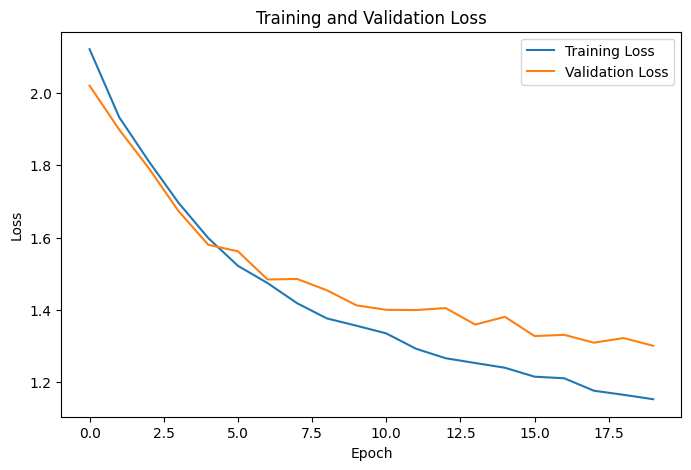

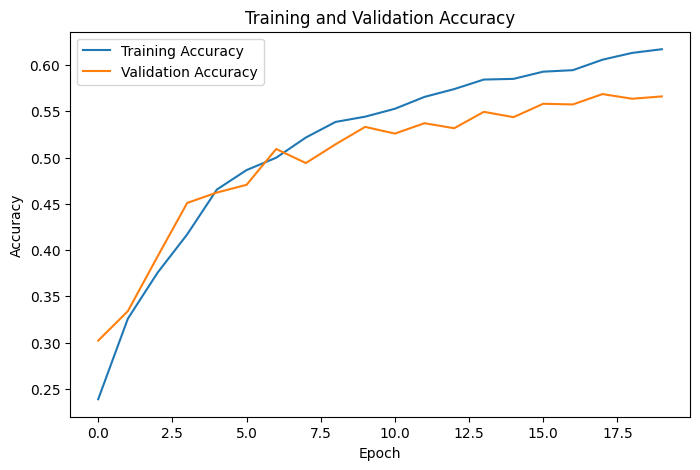

In [84]:
import matplotlib.pyplot as plt
# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()